In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import opengm

In [2]:
# convert RGB to luminance image
def rgb2bw(img):
    return 0.2126*img[...,0] + 0.7152*img[..., 1] + 0.0722*img[..., 2]

<matplotlib.colorbar.Colorbar instance at 0x7f0279d8c908>

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


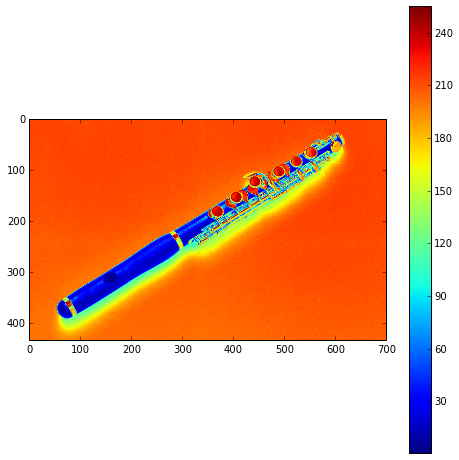

In [4]:
img = plt.imread('flute.jpg')
img = rgb2bw(img)

dimx = img.shape[1]
dimy = img.shape[0]
numLabels = 3
numVar = dimx*dimy

plt.figure(figsize=(8,8))
plt.imshow(img)
plt.colorbar()

In [22]:
# Building up graphical model

numberOfStates = np.ones(numVar, dtype=opengm.index_type)*numLabels
gm = opengm.graphicalModel(numberOfStates, operator='adder')

varIndex = lambda x, y: x*dimy + y

In [23]:
# unary factors

metal_average = 230
lumber_average = 35.
bg_average = 200.

for y in range(dimy):
    for x in range(dimx):
        fid = gm.addFunction(np.array(
                [np.abs(metal_average - img[y, x]),
                 np.abs(lumber_average - img[y, x]),
                 np.abs(bg_average - img[y,x])]))
        gm.addFactor(fid, varIndex(x, y))


In [24]:
solver = opengm.inference.AlphaExpansion(gm)
solver.infer()
argmin = solver.arg()
segm_unaryOnly = argmin.reshape(dimx,dimy).transpose()

In [31]:
# smoothness factors

C = 30.
#f = (np.eye(numLabels, k=1) + np.eye(numLabels, k=-1))*C
f = (np.eye(3)-1)*(-C)


fid = gm.addFunction(f)

for y in range(dimy):
    for x in range(dimx):
        if (x+1 < dimx):
            gm.addFactor(fid, [varIndex(x,y), varIndex(x+1,y)])
        if (y+1 < dimy):
            gm.addFactor(fid, [varIndex(x,y), varIndex(x,y+1)])
            


In [32]:
solver = opengm.inference.AlphaExpansion(gm)
solver.infer()
argmin = solver.arg()
segm_smooth = argmin.reshape(dimx,dimy).transpose()

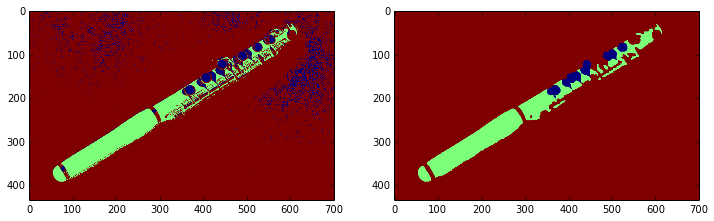

In [33]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(121)
ax1.imshow(segm_unaryOnly)

ax2 = fig.add_subplot(122)
ax2.imshow(segm_smooth)